In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

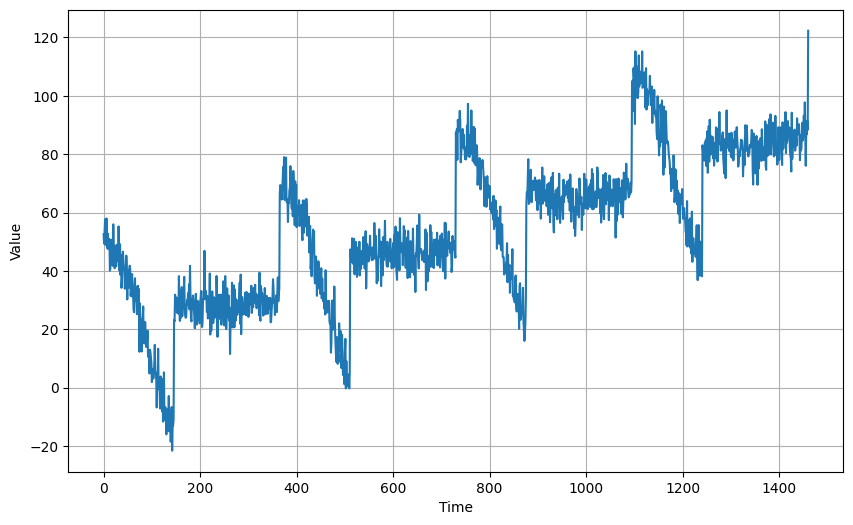

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [4]:
split_size = 1000
time_train = time[:split_size]
x_train = series[:split_size]

time_valid = time[split_size:]
x_valid = series[split_size:]

In [5]:
def foo(series, window_size,shift, shuffle, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
    
    dataset = dataset.map(lambda w: (w[:-1], w[-1]))
    dataset = dataset.shuffle(shuffle)
    dataset = dataset.batch(batch_size)
    
    return dataset

In [6]:
window_size = 20
shift = 1
shuffle = 1000
batch_size = 32
dataset = foo(x_train, window_size,shift, shuffle, batch_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10 ,input_shape=[window_size], activation='relu'),
    tf.keras.layers.Dense(10 , activation='relu'),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, epochs=100)

Epoch 1/100
31/31 [==============================] - 4s 99ms/step - loss: 801.5075
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 88.7444
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 83.4269
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 79.6232
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 77.6871
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 76.1412
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 74.0639
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 72.8083
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 71.2327
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 69.3837
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 67.7695
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 66.3871
Epoch 13/100
31/31 [===

In [31]:
forecast_series = series[split_size - window_size:]
forecast = []

for time in range(len(forecast_series ) - window_size):
    forecast.append(model.predict(forecast_series[time: time+window_size][np.newaxis]))
    

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


In [32]:
results = np.array(forecast).squeeze()

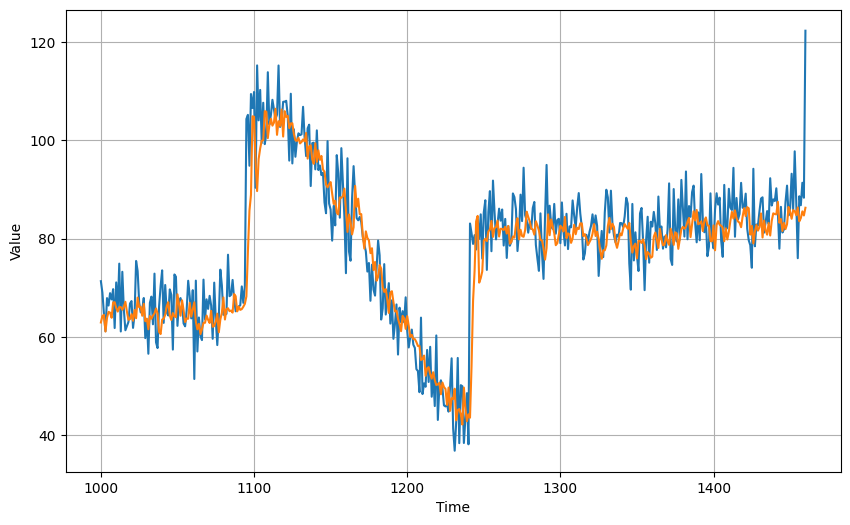

In [33]:
plot_series(time_valid, (x_valid, results))